**Table of contents**<a id='toc0_'></a>    
- 1. [Count earthquakes around New-Zealand tremor  ](#toc1_)    
- 2. [Load datasets   ](#toc2_)    
  - 2.1. [Load tremor catalog ](#toc2_1_)    
  - 2.2. [Load earthquakes   ](#toc2_2_)    
- 3. [Project along-strike](#toc3_)    
- 4. [Count earthquakes around tremor](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Count earthquakes around New-Zealand tremor   [&#128285;](#toc0_)

In [48]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd

import requests
import io

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets    [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Load tremor catalog  [&#128285;](#toc0_)

In [52]:
# Load the data
path = workdir + 'projects/data/Catalogs/nz_todd16_1015/nz_tremor_todd16_1015.csv'
names = ['date', 'lat', 'lon']
trm = pd.read_csv(path, names=names, skiprows=1)
trm['date'] = pd.to_datetime(trm['date'])

day0 = np.datetime64('2004-01-01')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

## 2.2. <a id='toc2_2_'></a>Load earthquakes    [&#128285;](#toc0_)

In [53]:
# Load geonet catalog
url1 = "https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2013-03-01&enddate=2016-01-01T0:00:00"
url2 = "https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-07-01&enddate=2013-03-01"
url3 = "https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-01-01T0:00:00&enddate=2010-07-01"

eq = pd.DataFrame()
for url in [url1, url2, url3]:
    print(url)
    eq = pd.concat([eq, pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))])

eq['date'] = pd.to_datetime(eq['origintime'])
eq = eq.sort_values('date')
eq.reset_index(drop=True, inplace=True)

eq = eq[['date', 'longitude', 'latitude', 'depth', 'magnitude']]
eq.rename(columns={'longitude': 'lon', 'latitude': 'lat', 'magnitude': 'mag'}, inplace=True)

https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2013-03-01&enddate=2016-01-01T0:00:00
https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-07-01&enddate=2013-03-01
https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-01-01T0:00:00&enddate=2010-07-01


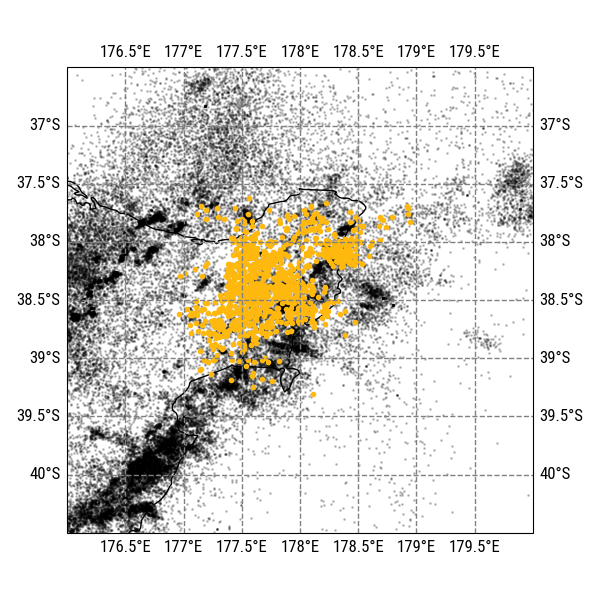

In [54]:
# Quick map
fig = plt.figure(figsize=(6, 6))

minlon = eq.lon.min()
maxlon= eq.lon.max()
minlat = eq.lat.min()
maxlat = eq.lat.max()

extent = [minlon, maxlon, minlat, maxlat]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

ax.plot(eq.lon, eq.lat, 'o', c=to_rgba('k', .2), ms=1, transform=ccrs.PlateCarree())
ax.plot(trm.lon, trm.lat, 'o', c=to_rgba('C2', 1), ms=3, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=1, linestyle='--', zorder=-1)

ax.set_extent(extent)
plt.tight_layout()
plt.show()

In [55]:
# Project tremor onto slab
# --> Load slab
path = workdir + "projects/data/Slabs/new_zealand/ker_slab2_dep_02.24.18.xyz"
slab = pd.read_csv(path, names=['lon', 'lat', 'depth'], sep=',')

slab = slab[(slab.lon > minlon) & (slab.lon < maxlon) & (slab.lat > minlat) & (slab.lat < maxlat) & (~np.isnan(slab.depth))]
slab.reset_index(drop=True, inplace=True)

# --> Find nearest neighbor on slab and give it its depth
# Convert to cartesian coordinates
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(crs, trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(crs, eq.lon.values, eq.lat.values)
slab_coords = crs.transform_points(crs, slab.lon.values, slab.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
slab.loc[:, 'x'] = slab_coords[:, 0]/1000
slab.loc[:, 'y'] = slab_coords[:, 1]/1000

# --> Find nearest neighbor
from scipy.spatial import cKDTree
tree = cKDTree(slab[['x', 'y']].values)
dist, idx = tree.query(trm[['x', 'y']].values)
trm['depth'] = slab.loc[idx, 'depth'].values

# 3. <a id='toc3_'></a>Project along-strike [&#128285;](#toc0_)

In [56]:
# Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)
slab_coords = crs.transform_points(ccrs.PlateCarree(), slab.lon.values, slab.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
slab.loc[:, 'x'] = slab_coords[:, 0]/1000
slab.loc[:, 'y'] = slab_coords[:, 1]/1000

In [57]:
# Define along-strike: fit a polynomial to the tremor line
p_strike = np.polyfit(trm.x[abs(trm.depth+25) < 1], trm.y[abs(trm.depth+25) < 1], 1)
# p_strike_slab = np.polyfit(slab.x[abs(slab.depth+25) < 2], slab.y[abs(slab.depth+25) < 2], 3)

# # Show
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_aspect('equal')
# ax.set_xlabel('x (km)')
# ax.set_ylabel('y (km)')

# ax.scatter(trm.x, trm.y, s=1, c='k')

# x = np.arange(-100, 100, 1)
# y = np.polyval(p_strike, x)
# ax.plot(x, y, 'r', zorder=10)

# plt.tight_layout()
# plt.show()

In [58]:
# Project along-strike: nearest point from each event to the strike line
# --> Define a strike line with evenly spaced points along it
x0, y0 = -100, np.polyval(p_strike, -100)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 110:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor
from scipy.spatial import cKDTree

tree = cKDTree(np.column_stack((X, Y)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.x, trm.y)))
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))

trm_along_strike_dist = S[trm_nearest_idx]
eq_along_strike_dist = S[eq_nearest_idx]

trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist
eq['xf'] = eq_along_strike_dist
eq['yf'] = eq_across_strike_dist

# # Show
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('x (km)')  
#     ax.set_ylabel('y (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(trm.x, trm.y, s=10, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=250)

# axes[1].scatter(trm.x, trm.y, s=10, c=trm_across_strike_dist, cmap='viridis', vmax=50)

# plt.tight_layout()
# plt.show()

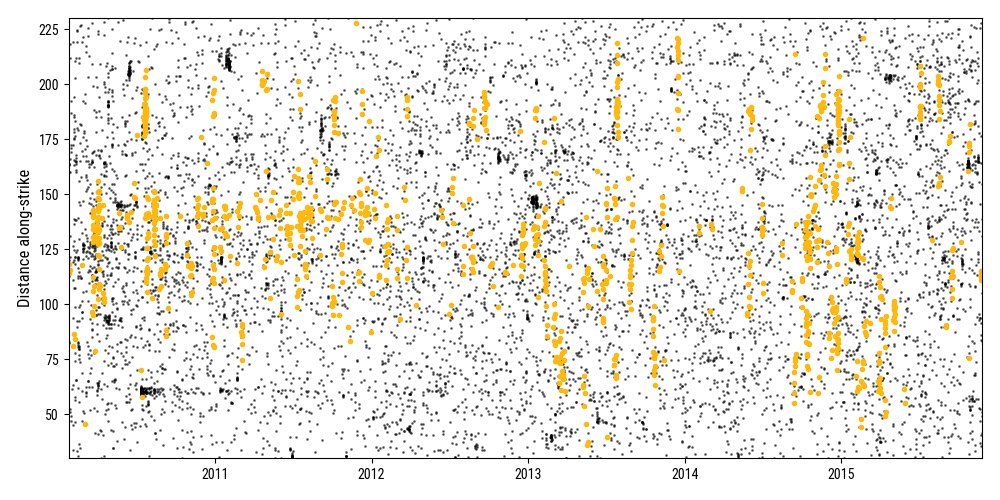

In [59]:
# Quick look
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_ylabel('Distance along-strike')
ax.plot(trm.date, trm.xf, 'o', ms=3, c='C2', zorder=1)
ax.plot(eq.date[abs(eq.yf) < 50], eq.xf[abs(eq.yf) < 50], 'o', ms=1, c=to_rgba('k', .5), zorder=0)

ax.set_ylim(30, 230)
ax.set_xlim(trm.date.min(), trm.date.max())

plt.tight_layout()
plt.show()

# 4. <a id='toc4_'></a>Count earthquakes around tremor [&#128285;](#toc0_)

In [60]:
epicentral = False

In [67]:
# Which earthquakes
interval = [np.datetime64('2010-01-01'), np.datetime64('2016-01-01')]

min_mag = 2.4

selected_eq = eq[(eq.date.values >= interval[0]) & (eq.date.values < interval[1]) & (eq.mag >= min_mag)]
print('{:d} events in the selected region between {:s} and {:s} with magnitude >= {:s}'.format(len(selected_eq), str(interval[0]), str(interval[1]), str(min_mag)))

16847 events in the selected region between 2010-01-01 and 2016-01-01 with magnitude >= 2.4


In [68]:
# Compute the number of earthquakes at a close distance for each tremor (~40s for 80k events, 2min for 170k events)
from scipy.spatial import cKDTree

dists = [10, 20, 30, 50, 100]

n_eq = np.zeros((len(dists), len(trm)))   # number of earthquakes at given distance of each tremor event
eq_at_dist = np.zeros((len(dists), len(selected_eq))).astype(bool)  # boolean array to keep track of which earthquakes are within given distance from any tremor

# Build K-D trees
if epicentral:
    eq_tree = cKDTree(selected_eq[['x', 'y']].values)
    trm_tree = cKDTree(trm[['x', 'y']].values)
else:
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)

# Look for pairs of earthquakes and tremors within distance
for jj, dist in enumerate(dists):
    # Find earthquakes within distance of tremors
    eq_idx = trm_tree.query_ball_tree(eq_tree, dist)
    
    # --> How earthquakes at distance from tremor
    n_eq[jj, :] = np.array([len(e) for e in eq_idx])
    
    # --> Which ones
    eq_at_dist_idx = np.concatenate(eq_idx)
    eq_at_dist_idx = np.unique(eq_at_dist_idx).astype(int)
    eq_at_dist[jj, eq_at_dist_idx] = True

In [69]:
# Convert counts to rates per year
n_eq = n_eq / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

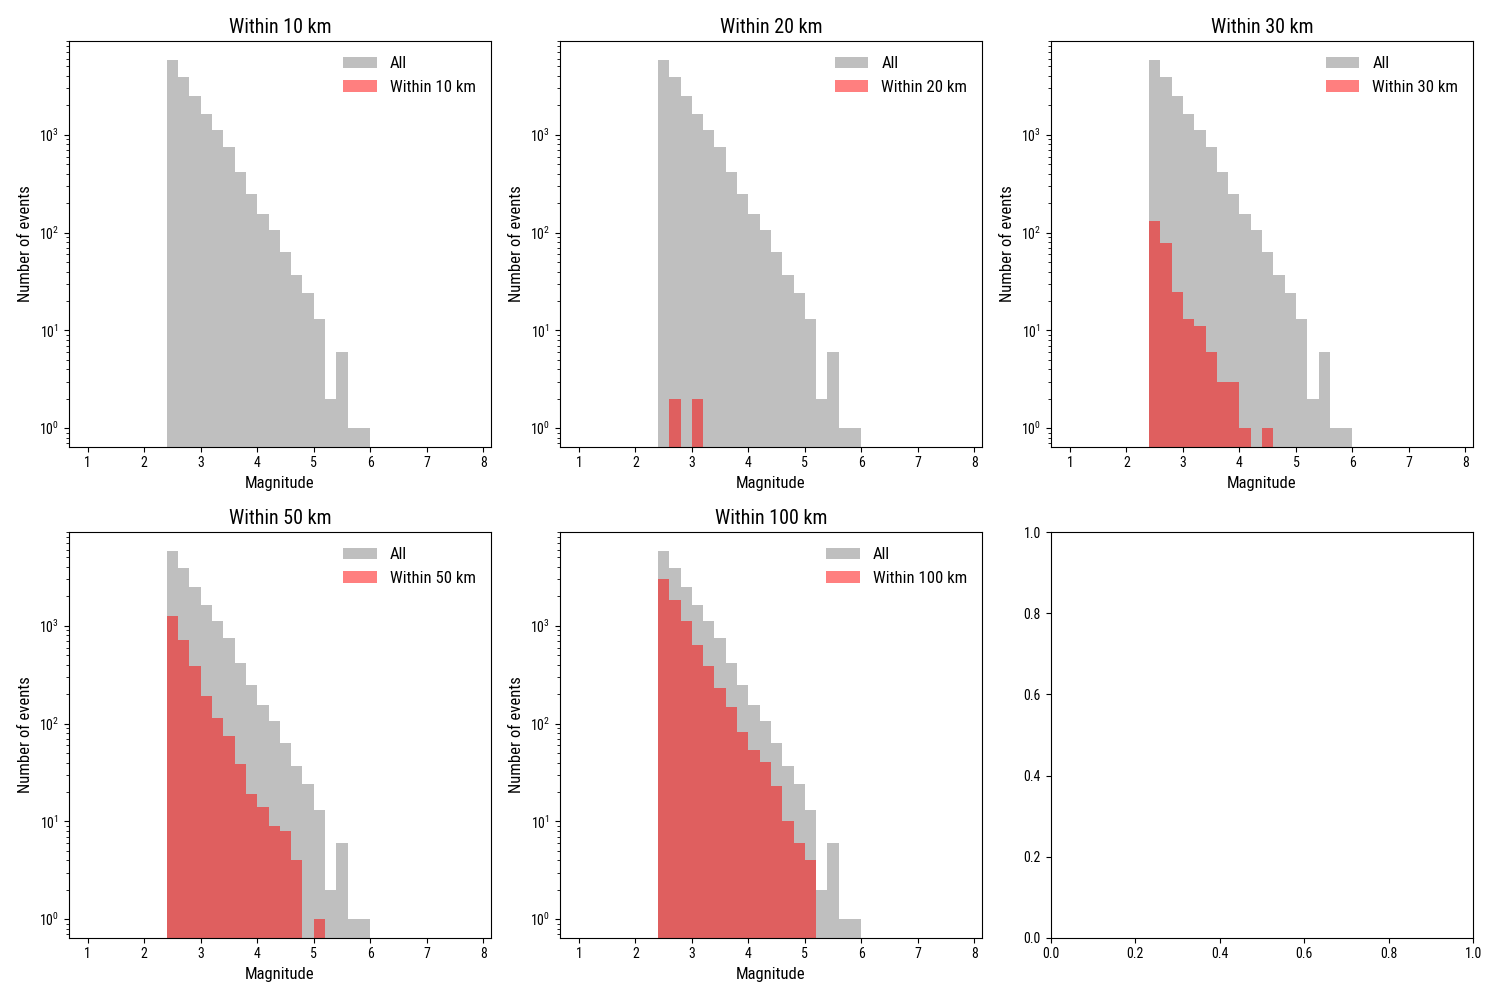

In [70]:
# Magnitude of completeness of each group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for jj, dist in enumerate(dists):
    ax = axes.flat[jj]
    ax.hist(selected_eq.mag, bins=np.arange(1, 8, .2), color='gray', alpha=.5, label='All', zorder=0)
    ax.hist(selected_eq.mag[eq_at_dist[jj]], bins=np.arange(1, 8, .2), color='red', alpha=.5, label='Within {:d} km'.format(dist), zorder=1)
    ax.set_title('Within {:d} km'.format(dist))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of events')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [72]:
# Save it
trm.loc[:, 'n_eq_10km'] = n_eq[0, :]
trm.loc[:, 'n_eq_20km'] = n_eq[1, :]
trm.loc[:, 'n_eq_30km'] = n_eq[2, :]
trm.loc[:, 'n_eq_50km'] = n_eq[3, :]
trm.loc[:, 'n_eq_100km'] = n_eq[4, :]

trm.to_csv('data/hikurangi/processed/hiku_trm_0110_0116_eqdist_mc{:.1f}.csv'.format(min_mag), index=False, date_format='%Y-%m-%d %H:%M:%S.%f')

# Save the earthquakes
selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
selected_eq.loc[:, 'in30km'] = eq_at_dist[2, :]
selected_eq.loc[:, 'in50km'] = eq_at_dist[3, :]
selected_eq.loc[:, 'in100km'] = eq_at_dist[4, :]

selected_eq.to_csv('data/hikurangi/processed/hiku_eqmc{:.1f}_0110_0116_eqdist.csv'.format(min_mag), index=False, date_format='%Y-%m-%d %H:%M:%S.%f')